A comparison between the initial behaviours of the original and the new implementation.

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

import slimpletic as st

assert jax.config.read('jax_enable_x64')

Here we setup the parameters for the system.

In [44]:
# System parameters, used in both methods
m = 1.0
k = 1.0
ll = 1e-4 * np.sqrt(m * k)  # ll is $\lambda$ in the paper

# Simulation and Method parameters
dt = 0.1 * np.sqrt(m / k)
t_sample_count = 1
tmax = t_sample_count * np.sqrt(m / k)
t0 = 0
t = t0 + dt * np.arange(0, t_sample_count + 1)
r = 0

# Initial conditions
q0 = [1.]
pi0 = [0.25 * dt * k]

Now the system dynamics

In [45]:
def lagrangian_f(q, qdot, t):
    return 0.5 * m * jnp.dot(qdot, qdot) - 0.5 * k * jnp.dot(q, q) ** 2

In [47]:
def create_original():
    from sympy import Symbol
    from original import slimplectic

    dho = slimplectic.GalerkinGaussLobatto('t', ['q'], ['v'])
    L = 0.5 * m * np.dot(dho.v, dho.v) - 0.5 * k * np.dot(dho.q, dho.q)
    # DHO:
    K = -ll * np.dot(dho.vp, dho.qm)
    # No damping:
    K_nd = Symbol('a')
    dho.discretize(L, K_nd, r, method='implicit', verbose=False)
    return dho


dho = create_original()

In [50]:
def format_original(original_results):
    return np.vstack([
        np.array(original_results[0]),
        np.array(original_results[1])
    ]).T


def format_jax(jax_results):
    return np.vstack(
        [
            np.array(jax_results[0]),
            np.array(jax_results[1])
        ],
    ).T

## Original Implementation

In [51]:
original_results = dho.integrate(q0, pi0, t)
original_results_fmt = format_original(original_results)
original_results_fmt

pi_np1_func: pi_np1_vec = [0.5*h_{GGL}*(-1.0*{q^{[n+1]}} + 0.5*(2*{q^{[n+1]}} - 2.0*{q^{[n]}})/h_{GGL}**2) + 0.25*(2*{q^{[n+1]}} - 2.0*{q^{[n]}})/h_{GGL}] in context [{q^{[n]}}, {q^{[n+1]}}, \pi_q^{[n]}, t, h_{GGL}] = [1.0, 0.9975, 0.025, 0.0, 0.1]
pi_np1_func: pi_np1_vec = [0.5*h_{GGL}*(-1.0*{q^{[n+1]}} + 0.5*(2*{q^{[n+1]}} - 2.0*{q^{[n]}})/h_{GGL}**2) + 0.25*(2*{q^{[n+1]}} - 2.0*{q^{[n]}})/h_{GGL}] in context [{q^{[n]}}, {q^{[n+1]}}, \pi_q^{[n]}, t, h_{GGL}] = [0.9975, 0.9850250000000002, -0.07487499999999947, 0.1, 0.1]


array([[ 1.      ,  0.025   ],
       [ 0.9975  , -0.074875]])

In [55]:
*jax_results, debug_info = st.iterate(
    lagrangian=lagrangian_f,
    q0=jnp.array(q0),
    pi0=jnp.array(pi0),
    dt=dt,
    t0=0,
    t_sample_count=t_sample_count,
    r=r,
    debug=True
)

jax_results_fmt = format_jax(jax_results)
jax_results_fmt

qi_values [[1.00374847]
 [0.9961356 ]]
pi_current [0.025] pi_next [-0.17497392]


array([[ 1.        ,  0.025     ],
       [ 0.9961356 , -0.17497392]])

In [53]:
jax_results_fmt - original_results_fmt

array([[ 0.        ,  0.        ],
       [-0.0013644 , -0.10009892]])

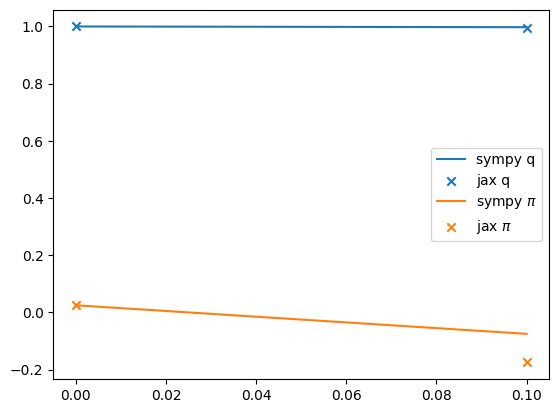

In [56]:
plt.plot(t, original_results_fmt[:, 0], label='sympy q', color='C0')
plt.scatter(t, jax_results_fmt[:, 0], label='jax q', color='C0', marker='x')
plt.plot(t, original_results_fmt[:, 1], label='sympy $\pi$', color='C1', )
plt.scatter(t, jax_results_fmt[:, 1], label='jax $\pi$', color='C1', marker='x')
plt.legend()

In [35]:
dho._pi_np1_map(
    np.array([2, 1]),
    np.array([3]),
    np.array([-3]),
    t0,
    dt
)

pi_np1_func: pi_np1_vec = [0.5*h_{GGL}*(-1.0*{q^{[n+1]}} + 0.5*(2*{q^{[n+1]}} - 2.0*{q^{[n]}})/h_{GGL}**2) + 0.25*(2*{q^{[n+1]}} - 2.0*{q^{[n]}})/h_{GGL}] in context [{q^{[n]}}, {q^{[n+1]}}, \pi_q^{[n]}, t, h_{GGL}] = [3, 2, -3, 0, 0.1]


array([-10.1])

In [13]:
debug_info['compute_pi_next'](
    jnp.array([3, 2.0]),
    t0
)

Array(-10.8, dtype=float64)

And here is where we leave this mess:

- Why are these numbers different, they seem much closer though. Do a random spot test to check for rough coincidence.
- Why does the sympy version seem to be assigning the wrong values to the wrong variables?
- Verify `Convert_EOM_Args` does what I think it does 

In [36]:
jax.grad(debug_info['lagrangian_d'], argnums=0)(
    jnp.array([0.1, 0]),
    t0
)

Array([ 0.9999, -1.    ], dtype=float64)

In [37]:
jnp.array(pi0)

Array([0.025], dtype=float64)

In [38]:
debug_info['residue'](jnp.array(dho.qi_sol_list[0]), 0, jnp.array(pi0))

Array([0.025], dtype=float64)

In [39]:
debug_info['optimize_qi'](
    jnp.array([0.1, 0]),
    t0
)

KeyError: 'optimize_qi'

In [40]:
dho.debug_escape_info['EOM_Val_Vec'](
    jnp.array(dho.qi_sol_list[0]),
    q0,
    pi0,
    0,
    0.1
)

array([9.975])

In [ ]:
dho.qi_sol_list[0]

In [ ]:
debug_info

In [18]:
from slimpletic.helpers import fill_out_initial

fill_out_initial(
    jnp.array(q0),
    r=r
)

Array([[1.],
       [1.]], dtype=float64)

In [22]:
from jaxopt import GaussNewton

opt = GaussNewton(residual_fun=debug_info['residue'])
opt_res = opt.run(
    fill_out_initial(
        jnp.array(q0),
        r=r
    ),
    t0,
    jnp.array(pi0)
)

In [23]:
opt_res.params

OptStep(params=Array([[1.00374847],
       [0.9961356 ]], dtype=float64), state=GaussNewtonState(iter_num=Array(2, dtype=int64, weak_type=True), residual=Array([-4.22010452e-06], dtype=float64), value=Array(8.9046411e-12, dtype=float64), delta=Array([[-2.10905885e-07],
       [ 2.17479265e-07]], dtype=float64), error=Array(3.02949704e-07, dtype=float64), gradient=Array([[-4.09255053e-05],
       [ 4.22010452e-05]], dtype=float64), aux=None))

In [25]:
dho.debug_escape_info['EOM_Val_Vec'](
    opt_res.params,
    q0,
    pi0,
    0,
    0.1
)

array([[-0.06248472]])

In [26]:
jnp.array(dho.qi_sol_list[0])

Array([0., 0.], dtype=float64)

In [27]:
opt_res.params

Array([[1.00374847],
       [0.9961356 ]], dtype=float64)

Why are those so different I thought they were the same thing??